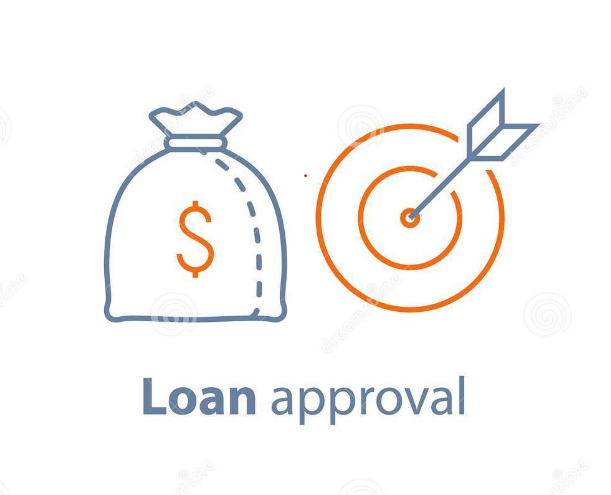

### Purpose of this Model:

Build a strategy to grant loans.     
Specifically, we should build a model which is better than the bank's loan grant model.

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Import Data](#1)  
1. [Data Quality Check](#2)
1. [Exploratory Data Analysis](#3)
1. [Model Framework Design](#4)
1. [Data Preprocessing](#5)
1. [Model Build](#6)
1. [Optimization](#7)
1. [Model Evaluation](#8)
1. [Score - Ungranted Loans](#9)
1. [Model Profitability Compariso](#10)

#### Libraries

In [ ]:
import collections

import numpy as np
import pandas as pd

# Visualisation
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# sklearn
# from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn import tree

# Save model
import pickle


#### User Defined Functions

In [ ]:
def diff(li1, li2):
    '''
    This function returns different elements between 2 lists
    '''
    return (list(set(li1) - set(li2)))

def plot_stats(df, feature, target_ftr, label_rotation=False, horizontal_layout=True):
    '''
    This function plot the categorical feature distribution according to target variable
    '''
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of repaid-loans': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, target_ftr]].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by=target_ftr, ascending=False, inplace=True)
    
    sns.set_color_codes("pastel")
    s = sns.barplot(x = feature, y="Number of repaid-loans",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=60)

    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();


def get_rocauc(model, xTest, yTest): 
    '''
    This function produces the Area under the curve for the model. 
    The 'auto' method calculates this metric by using the roc_auc_score function from sklearn.
    Range: 0 to 1 (0 being the worst predictive model, 0.5 being the random and 1 being the best)
    '''
    predictions = model.predict_proba(xTest)[:, 1]
    roc_auc = roc_auc_score(yTest, predictions)
    print('Model Performance:')
    print('--'*5)
    print('--'*5)
    print('ROC = {:0.2f}%'.format(roc_auc))
    
    return roc_auc

def plot_roc(yTest, yPred):
    '''
    This function plots the ROC and gives the AUC.
    Range for Area under the curve : 0 to 1 (0 being the worst and 1 being best for predictive model)
    '''
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    roc_auc = roc_auc_score(yTest, yPred)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='random')
    plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def perf_measure(y_actual, y_pred):
    '''
    Function for calculating TP, FP, TN and FN
    '''
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

def capture_curve(test_df, y_test, preds, roc, title):
    '''
    Function for to plot capture curve for risky or non-repaid loans
    This is similar to gain and lift chart in statistics.
    x-axis: Population % of granted loans
    y-axis: Risk / Non-repaid loan %
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    rate = []
    for i in threshold:
        T = perf_measure(list(y_test),[1 if j >= i else 0 for j in preds])
        rate.append(T[0]+T[1])
    rate2 = [i/len(test_df) for i in rate]
    plt.figure(figsize=[12,12])
    plt.plot(rate2, tpr, label='ROC_AUC {}'.format(roc) % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Granted Loans', fontsize=18)
    plt.ylabel('Captured out of total non-repaid proportion', fontsize=18)
    plt.title('Capture plot for {}'.format(title), fontsize=18)
    plt.legend(loc="lower right",prop={'size':30})
    plt.show()

def decile_cutoff_risk_detected(df_pred):
    '''
    Function to find the decile-wise risky loan application %
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    risk_perc_list = []
    risk_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_risk = pd.DataFrame(columns=['loan_percentage','non-repaid_percentage', '#non-repaid_loans', 'avg_pred_prob'])
    total_risk_count = df_pred[df_pred['loan_quality']==1]['loan_id'].count()
    start = 0
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[start:split_len]
        risk_count = sorted_results_final[sorted_results_final['loan_quality']==1]['loan_id'].count()
        min_pred_prob = sorted_results_final['preds'].min()
        max_pred_prob = sorted_results_final['preds'].max()
        avg_pred_prob = sorted_results_final['preds'].mean()
        perc_list.append(int(perc*100))
        risk_perc_list.append(round(((risk_count/total_risk_count)*100),2))
        risk_num_list.append(round(risk_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
        start = split_len
    df_pop_risk['loan_percentage'] = perc_list
    df_pop_risk['non-repaid_percentage'] = risk_perc_list  
    df_pop_risk['#non-repaid_loans'] = risk_num_list
    df_pop_risk['min_pred_prob'] = min_pred_prob_list
    df_pop_risk['max_pred_prob'] = max_pred_prob_list
    df_pop_risk['avg_pred_prob'] = avg_pred_prob_list
    return df_pop_risk

def cum_decile_cutoff_risk_detected(df_pred):
    '''
    Function to find the decile-wise risky loan application %
    '''
    pop_perc = list(np.arange(0.1,1.1,0.1))
    perc_list = []
    risk_perc_list = []
    risk_num_list = []
    avg_pred_prob_list = []
    min_pred_prob_list = []
    max_pred_prob_list = []
    df_pop_risk = pd.DataFrame(columns=['loan_percentage','non-repaid_percentage', '#non-repaid_loans', 'avg_pred_prob'])
    total_risk_count = df_pred[df_pred['loan_quality']==1]['loan_id'].count()
    for perc in pop_perc:
        split_len = int(perc*len(df_pred))
        sorted_results_final = df_pred.iloc[:split_len]
        risk_count = sorted_results_final[sorted_results_final['loan_quality']==1]['loan_id'].count()
        min_pred_prob = sorted_results_final['preds'].min()
        max_pred_prob = sorted_results_final['preds'].max()
        avg_pred_prob = sorted_results_final['preds'].mean()
        perc_list.append(int(perc*100))
        risk_perc_list.append(round(((risk_count/total_risk_count)*100),2))
        risk_num_list.append(round(risk_count,2))
        min_pred_prob_list.append(round(min_pred_prob, 2))
        max_pred_prob_list.append(round(max_pred_prob, 2))
        avg_pred_prob_list.append(round(avg_pred_prob, 2))
    df_pop_risk['loan_percentage'] = perc_list
    df_pop_risk['non-repaid_percentage'] = risk_perc_list  
    df_pop_risk['#non-repaid_loans'] = risk_num_list
    df_pop_risk['min_pred_prob'] = min_pred_prob_list
    df_pop_risk['max_pred_prob'] = max_pred_prob_list
    df_pop_risk['avg_pred_prob'] = avg_pred_prob_list
    return df_pop_risk

def profitability_diff(score1_name, score2_name, score1, score2):
    '''
    This function takes 2 scores as input and gives Absolute Difference between scores as output
    '''
    if score1 > score2:
        print('%s is %d point better than %s' % (score1_name, abs(score1 - score2), score2_name))
        print('--'*30)
        print('%s is %f times better than %s' % (score1_name, (score1/score2), score2_name))
    else:
        print('%s is %d point better than %s' % (score2_name, abs(score1 - score2), score1_name))
        print('--'*30)
        print('%s is %f times better than %s' % (score2_name, (score2/score1), score1_name))


## 1. Import Data <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

### 1.1 Source Directory Path

In [ ]:
# Directory Path
dir_path = '../input/bank-loan-data/'

### 1.2 Borrower Details

In [ ]:
borrower = pd.read_csv(dir_path + 'borrower_table.csv')
print(borrower.shape)
borrower.head(3)

### 1.3 Loan Details

In [ ]:
loan = pd.read_csv(dir_path + 'loan_table.csv')
print(loan.shape)
loan.head(3)

## 2. Data Quality Check <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

### 2.1 Duplicate Check

In [ ]:
print(f'There are {loan.shape[0] - loan.loan_id.nunique()} duplicates for loan id in the loan table')
print(f'There are {borrower.shape[0] - borrower.loan_id.nunique()} duplicates for loan id in the borrower table')

### 2.2 ***loan_id*** comparison

In [ ]:
borrower_loan_id = list(borrower['loan_id'])
loan_loan_id = list(loan['loan_id'])

if collections.Counter(borrower_loan_id) == collections.Counter(loan_loan_id): 
    print ("All the loan ids are same") 
else : 
    print ("Different loan ids are present in both the datasets") 

* Cross check with set difference option

In [ ]:
print(diff(borrower_loan_id, loan_loan_id))

* All the loan ids are same in both the dataframes
* Now both the datasets can be merged and analyzed.

In [ ]:
# Merge Dataframes

df_loan = loan.merge(borrower, how='left', on='loan_id')
print(df_loan.shape)
df_loan.head(3)

### 2.3 Datatype

In [ ]:
print(df_loan.info())

### 2.4 Statistics

In [ ]:
# Numerical features

df_loan.describe().transpose()

### 2.5 Missing Value Analysis

In [ ]:
# Calculate missing value count and percentage

missing_value_df_loan = pd.DataFrame(index = df_loan.keys(), data =df_loan.isnull().sum(), columns = ['Missing_Value_Count'])
missing_value_df_loan['Missing_Value_Percentage'] = np.round(((df_loan.isnull().mean())*100),2)
missing_value_df_loan.sort_values('Missing_Value_Count',ascending= False)

* **loan_repaid** can be null because of non-grant of loan itself.
* **fully_repaid_previous_loans, currently_repaying_other_loans** can also be null in case of first loan.
* **avg_percentage_credit_card_limit_used_last_year** needs to be analysed further before any treatment (imputation).

## 3. Exploratory Data Analysis <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

### 3.1 Correlation

In [ ]:
# Make correlation table according to spearman's correlation

corr_spearman = df_loan.corr()
corr_spearman

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_spearman, dtype=np.bool))

# Visualisation of heatmap matrix
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr_spearman, mask=mask, annot = True)

### 3.2 Feature Analysis

* Create different datasets for granted & ungranted and repaid & non-repaid segments

In [ ]:
# granted & ungranted

granted   = df_loan.loc[(df_loan['loan_granted'] == 1)]
ungranted = df_loan.loc[(df_loan['loan_granted'] == 0)]

In [ ]:
# repaid & non-repaid

repaid     = granted.loc[(granted['loan_repaid'] == 1)]
non_repaid = granted.loc[(granted['loan_repaid'] == 0)]

#### 3.2.1 Target class Distribution

In [ ]:
# Class Imbalance check

temp_ln_rpd = granted['loan_repaid'].value_counts()
df_ln_rpd = pd.DataFrame({'labels': temp_ln_rpd.index,
                   'values': temp_ln_rpd.values})
plt.figure(figsize = (6,6))
plt.title('Application loans repaid')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df_ln_rpd)
locs, labels = plt.xticks()
plt.show()

* Class imbalance is not significant

#### 3.2.2 Uni-variate Analysis

* Categoricl Feature Distribution (repaid-loans)

In [ ]:
plot_stats(granted, 'dependent_number', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [ ]:
plot_stats(granted, 'loan_purpose', 'loan_repaid', label_rotation=True, horizontal_layout=True)

In [ ]:
plot_stats(granted, 'is_employed', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [ ]:
# How many of employed repay their loans
print('Employed who repay their loans (%) :')
print(round(((granted[(granted['is_employed']==1) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['is_employed']==1)].shape[0])*100,1))

print('--'*20)
print('--'*20)

# How many of un-employed repay their loans
print('Unemployed who repay their loans (%) :')
print(round(((granted[(granted['is_employed']==0) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['is_employed']==0)].shape[0])*100,1))


In [ ]:
plot_stats(granted, 'currently_repaying_other_loans', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [ ]:
# How many repay the loan while paying for another loan
print('People who repay their loans having existing loan payment (%) :')
print(round(((granted[(granted['currently_repaying_other_loans']==1) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['currently_repaying_other_loans']==1)].shape[0])*100,2))

print('--'*40)
print('--'*40)

# How many repay the loan when not paying for other loans
print('People who repay their loans not having any other loan payment (%) :')
print(round(((granted[(granted['currently_repaying_other_loans']==0) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['currently_repaying_other_loans']==0)].shape[0])*100,2))


In [ ]:
plot_stats(granted, 'fully_repaid_previous_loans', 'loan_repaid', label_rotation=False, horizontal_layout=True)

In [ ]:
# How many of people repay their loans who have fully repaid previous loans
print('People who repay their loans who have fully repaid previous loans (%) :')
print(round(((granted[(granted['fully_repaid_previous_loans']==1) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['fully_repaid_previous_loans']==1)].shape[0])*100,2))

print('--'*40)
print('--'*40)

# How many of people repay their loans who haven't fully repaid previous loans
print('People who repay their loans who have not fully repaid previous loans (%) :')
print(round(((granted[(granted['fully_repaid_previous_loans']==0) & (granted['loan_repaid']==1)].shape[0])/granted[(granted['fully_repaid_previous_loans']==0)].shape[0])*100,2))


* Continuous Feature Distribution (repaid-loans)

#### saving_amount

In [ ]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('saving_amount', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('saving_amount', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('saving_amount', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [ ]:
print(f'Average saving_amount by repaid group: {repaid["saving_amount"].median()}')
print(f'Average saving_amount by non-repaid group: {non_repaid["saving_amount"].median()}')
print(f'Average saving_amount by ungranted group: {ungranted["saving_amount"].median()}')

#### checking_amount

In [ ]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('checking_amount', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('checking_amount', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('checking_amount', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [ ]:
print(f'Average checking_amount by repaid group: {repaid["checking_amount"].median()}')
print(f'Average checking_amount by non-repaid group: {non_repaid["checking_amount"].median()}')
print(f'Average checking_amount by ungranted group: {ungranted["checking_amount"].median()}')

* saving_amount & checking_amount distribution looks similar

#### yearly_salary

In [ ]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('yearly_salary', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('yearly_salary', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('yearly_salary', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [ ]:
print(f'Average yearly_salary by repaid group: {repaid["yearly_salary"].median()}')
print(f'Average yearly_salary by non-repaid group: {non_repaid["yearly_salary"].median()}')
print(f'Average yearly_salary by ungranted group: {ungranted["yearly_salary"].median()}')

#### total_credit_card_limit

In [ ]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('total_credit_card_limit', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('total_credit_card_limit', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('total_credit_card_limit', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [ ]:
print(f'Average total_credit_card_limit by repaid group: {repaid["total_credit_card_limit"].median()}')
print(f'Average total_credit_card_limit by non-repaid group: {non_repaid["total_credit_card_limit"].median()}')
print(f'Average total_credit_card_limit by ungranted group: {ungranted["total_credit_card_limit"].median()}')

In [ ]:
fig, axes = plt.subplots(1, 3)

fig.set_size_inches(12, 4)

repaid.hist('avg_percentage_credit_card_limit_used_last_year', bins=100, ax=axes[0])
axes[0].set_xlabel('repaid')
non_repaid.hist('avg_percentage_credit_card_limit_used_last_year', bins=100, ax=axes[1])
axes[1].set_xlabel('non_repaid')
ungranted.hist('avg_percentage_credit_card_limit_used_last_year', bins=100, ax=axes[2])
axes[2].set_xlabel('ungranted')

plt.show()

In [ ]:
print(repaid['avg_percentage_credit_card_limit_used_last_year'].median())
print(non_repaid['avg_percentage_credit_card_limit_used_last_year'].median())
print(ungranted['avg_percentage_credit_card_limit_used_last_year'].median())

#### Others (For future scope)

  1. time period for which data is available
  2. How on each quarter, half-yearly, yearly loan trends
  3. Outlier Analysis

## 4. Model Framework Design <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

### 4.1 Target Definition and Model framework preparation

* loan_quality
   1. 1:  (loan_granted==1) & (loan_repaid==1)
   2. 0:  (loan_granted==1) & (loan_repaid==0)
* Train the model on loan_quality = 0 or 1
* Score on all the non-granted `loan_id`s
* Create decile based on predicted-probability. Check till which decile it is safe to grant loan.    
Needs to decide the risk threshold (how much risk we want to take). 
* Based on the decided risk threshold and the decile, we choose the crop to gain more on ungranted loans.

### 4.2 Features from sub-models

* Build 2 sub-models taking loan_granted & loan_repaid as targets  
* Use the scores for each loan_ids as 2 independent features in the final models

*** These 2 features are not used for now, due to time constraint, may be followed in future***



#### Check the values of loan_granted and loan_repaid

In [ ]:
print(df_loan['loan_granted'].unique())
print(df_loan['loan_repaid'].unique())

In [ ]:
print(df_loan.loc[df_loan.loan_granted ==0 ]['loan_repaid'].unique())
print(df_loan.loc[df_loan.loan_granted ==1 ]['loan_repaid'].unique())

#### Create the target: loan_quality

In [ ]:
df_loan.loc[((df_loan['loan_granted'] == 1) & (df_loan['loan_repaid'] == 1)), 'loan_quality'] = 0
df_loan.loc[((df_loan['loan_granted'] == 1) & (df_loan['loan_repaid'] == 0)), 'loan_quality'] = 1
df_loan.loc[(df_loan['loan_granted'] == 0), 'loan_quality'] = -1

In [ ]:
print(df_loan['loan_quality'].unique())
print('--'*10)
print(df_loan.loc[(df_loan['loan_granted']==1)&(df_loan['loan_repaid']==1)]['loan_quality'].unique())
print(df_loan.loc[(df_loan['loan_granted']==1)&(df_loan['loan_repaid']==0)]['loan_quality'].unique())
print(df_loan.loc[(df_loan['loan_granted']==0)]['loan_quality'].unique())

* Target is created according to a risk framework for model building.
   1. If loan is granted and not paid -> risk, mark it 1
   2. If loan is granted and paid -> risk, mark it 0
   
   3. for all the ungranted loans, -1 is just an indicator. Mathematical calculation will be different for business situation

## 5. Data Preprocessing <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Create a copy of the loan dataset for feature transformation

df_loan_tr = df_loan.copy()

### 5.1 New feature Creation

#### 5.1.1 New features from date variables

In [ ]:
# Cast the datatype of "date" field
df_loan_tr['date']= pd.to_datetime(df_loan_tr['date'])
df_loan_tr['date'].dtypes

In [ ]:
# Year from date
df_loan_tr['year'] = df_loan_tr['date'].dt.year

# Month from date
df_loan_tr['month'] = df_loan_tr['date'].dt.month

# Day from date
df_loan_tr['day'] = df_loan_tr['date'].dt.day

# Quarter from date
df_loan_tr['quarter'] = df_loan_tr['date'].dt.quarter

# Semester from date
df_loan_tr['semester'] = np.where(df_loan_tr.quarter.isin([1,2]),1,2)

# Day of the week from date
df_loan_tr['dayofweek'] = df_loan_tr['date'].dt.dayofweek

df_loan_tr[['date', 'year', 'month', 'day', 'quarter', 'semester', 'dayofweek']].head()

In [ ]:
# Check the unique day of week
df_loan_tr['dayofweek'].unique()

* All the loan data is in weekdays (0 to 4, i.e. Monday to Friday)

#### 5.1.2 Categorical feature Encoding

In [ ]:
# Unique values in loan_purpose

df_loan_tr["loan_purpose"].unique()

* As only 5 unique values are there, it can be label encoded.

In [ ]:
# Need to convert the datatypes of the feature to 'category' before Label encoding.
df_loan_tr["loan_purpose"] = df_loan_tr["loan_purpose"].astype('category')

# Label Encoding
df_loan_tr["loan_purpose_cat"] = df_loan_tr["loan_purpose"].cat.codes

df_loan_tr[["loan_purpose", "loan_purpose_cat"]].head(3)

### 5.2 Null Value Treatment: Imputation

In [ ]:
# Calculate missing value count and percentage

missing_value_df_loan_tr = pd.DataFrame(index = df_loan_tr.keys(), data =df_loan_tr.isnull().sum(), columns = ['Missing_Value_Count'])
missing_value_df_loan_tr['Missing_Value_Percentage'] = np.round(((df_loan_tr.isnull().mean())*100),2)
missing_value_df_loan_tr.sort_values('Missing_Value_Count',ascending= False)

* fully_repaid_previous_loans

In [ ]:
print(df_loan_tr['fully_repaid_previous_loans'].unique())
print(df_loan_tr.loc[df_loan_tr['fully_repaid_previous_loans'].isnull()]['is_first_loan'].unique())

# Impute fully_repaid_previous_loans with some numerical values for all the first loans



* currently_repaying_other_loans

In [ ]:
print(df_loan_tr['currently_repaying_other_loans'].unique())
print(df_loan_tr.loc[df_loan_tr['currently_repaying_other_loans'].isnull()]['is_first_loan'].unique())

# Impute currently_repaying_other_loans with some numerical values for all the first loans

* avg_percentage_credit_card_limit_used_last_year

In [ ]:
# print(df_loan_tr['avg_percentage_credit_card_limit_used_last_year'].unique())
print(df_loan_tr.loc[df_loan_tr['avg_percentage_credit_card_limit_used_last_year'].isnull()]['total_credit_card_limit'].unique())
print(df_loan_tr.loc[df_loan_tr['total_credit_card_limit']==0]['avg_percentage_credit_card_limit_used_last_year'].unique())

* avg_percentage_credit_card_limit_used_last_year is null when total_credit_card_limit is 0

* **Replace null with -1**

In [ ]:
# replace null with -1

df_loan_tr['fully_repaid_previous_loans'].fillna(-1, inplace=True)
df_loan_tr['currently_repaying_other_loans'].fillna(-1, inplace=True)
df_loan_tr['avg_percentage_credit_card_limit_used_last_year'].fillna(-1, inplace=True)


### 5.3 Feature Selection

In [ ]:
feature_set = ['is_first_loan', 
'fully_repaid_previous_loans', 
'currently_repaying_other_loans', 
'total_credit_card_limit', 
'avg_percentage_credit_card_limit_used_last_year', 
'saving_amount', 
'checking_amount', 
'is_employed', 
'yearly_salary',
'age', 
'dependent_number',
# 'month', 
# 'day', 
# 'quarter', 
# 'semester', 
# 'dayofweek', 
'loan_purpose_cat']

#### Granted and Ungranted Loans

* Granted Loans

In [ ]:
## Train and test on granted loans

granted_loan = df_loan_tr.loc[(df_loan_tr['loan_quality'] == 1) | (df_loan_tr['loan_quality'] == 0)]
print(f'#loan_id: {granted_loan.shape[0]} ')

In [ ]:
print('cross check the target values')
print('--'*15)
print(granted_loan['loan_quality'].unique())
print(granted_loan['loan_granted'].unique())
print(granted_loan['loan_repaid'].unique())

* Ungranted Loans

In [ ]:
## Predict / Score Population on ungranted loans

ungranted_loan = df_loan_tr.loc[(df_loan_tr['loan_quality'] == -1)]
print(f'#loan_id: {ungranted_loan.shape[0]} ')

In [ ]:
print('cross check the target values')
print('--'*15)
print(ungranted_loan['loan_quality'].unique())
print(ungranted_loan['loan_granted'].unique())
print(ungranted_loan['loan_repaid'].unique())

### 5.4 Train & Test Data Preparation

#### 5.4.1 Training and Validation Data Preparation

In [ ]:
train_granted = granted_loan.loc[~(granted_loan['month'].isin([1,2,3]))]
exog_train_granted = train_granted[feature_set]
endog_train_granted = train_granted['loan_quality']

print(train_granted.shape)

In [ ]:
# Insample train and validation split

x_train, x_val, y_train, y_val = train_test_split(exog_train_granted, endog_train_granted, test_size=0.1, random_state=42)


#### 5.4.2 Test Data Preparation

In [ ]:
test_granted = granted_loan.loc[(granted_loan['month'].isin([1,2,3]))]
exog_test = test_granted[feature_set]

print(test_granted.shape)

In [ ]:
test_granted['loan_quality'].unique()

## 6. Model Build <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

* Random Forest base version

In [ ]:
# Random Forest Model

rf = RandomForestClassifier(random_state = 42)

In [ ]:
# Parameters used by the current forest

print('Parameters currently in use:\n')
pprint(rf.get_params())

### 6.1 Base Model training and accuracy

In [ ]:
base_model = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = get_rocauc(base_model, x_val, y_val)

### 6.2 Cross - Validation

#### 6.2.1 5-fold cross validation

In [ ]:
# Compute cross-validated AUC scores for the training set: cv_auc

cv_auc = cross_val_score(base_model, x_train, y_train, cv=5, scoring = 'roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

* ROC from all the samples are around 0.96. Variation is negligible. We may move forward with this base model.

#### 6.2.2 Accuracy comparison - Different feature sets

* 3 variation of feature set

  **1. All the features (including newly created and transformed)**   
  ROC around 0.97 and good predicted probability range
  
  **2. All without `checking_amount` **   
  ROC around 0.94.   
  Although checking_amount looks multicollinear, but gives better accuracy when used and capture non-repaid loans more accurately
  
  **3. All without `newly created timestamp variables from date` **   
  ROC around 0.97   
  Best among all. better predicted probability range than the model using all the features   
  
    ***Option 3 is used while building the final model***

### 6.3 Feature importance

In [ ]:
features = exog_train_granted.columns
importances = base_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 6.4 Save the model into a pickle file

In [ ]:
# save the model to disk
filename = 'randomforest_basemodel'
pickle.dump(base_model, open(filename, 'wb'))

## 7. Optimization <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

### 7.1 Hyperparameter Optimization

#### 7.1.1 Define Hyperparameters for Chosing a Better Model

In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(1, 50, num = 15)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]


#### 7.1.2 Random Hyperparameter Grid

In [ ]:
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

#### 7.1.3 Random Search Training

In [ ]:
# rf1 = RandomForestClassifier()

# # Random search of parameters, using 3 fold cross validation
# # Search across 100 different combinations, and by using all available cores
# rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(x_train, y_train)


** Optimisation is saved for future**

##### Gradient Boosting can be tried as next step for optimisation

* xgboost and lightgbm can be used to check accuracy

## 8. Model Evaluation <a class="anchor" id="8"></a>

[Back to Table of Contents](#0.1)

* Predictions

In [ ]:
granted_model = pickle.load(open('randomforest_basemodel', 'rb'))
pred_test_granted = granted_model.predict_proba(exog_test)[:, 1]

print(pred_test_granted)

### 8.1 ROC

#### 8.1.1 ROC AUC

In [ ]:
roc_test_granted = roc_auc_score(list(test_granted['loan_quality']), pred_test_granted)
print(round(roc_test_granted,2))

#### 8.1.2 ROC Curve

In [ ]:
plot_roc(test_granted['loan_quality'], pred_test_granted)

### 8.2 Capture Plot

In [ ]:
capture_curve(test_granted, test_granted['loan_quality'], pred_test_granted, round(roc_test_granted,2), 'Granted Loans in 2012 Q1')

**The above is a capture plot for all the granted loans which are not going to repay**

* This shows the risk factors with the model developed.    
   All though the model is having 0.97 ROC_AUC, but not efficient of capturing the loans which are risky (not going to pay).   


* **Note:** ROC is here is just indicator, this is not a ROC curve.

### 8.3 Decile-wise risky applications calculation

In [ ]:
# Create a copy of test data
test_granted_preds=test_granted.copy()

In [ ]:
test_granted_preds['preds']=list(pred_test_granted)

In [ ]:
sorted_test_granted_preds = test_granted_preds.sort_values(by ='preds' , ascending=False)
sorted_test_granted_preds.shape

In [ ]:
test_granted_preds.shape

#### 8.3.1 Statistics Decile-wise

##### 8.3.1.1 Decile-wise statistics

In [ ]:
df_decile_cutoff_test_granted = decile_cutoff_risk_detected(sorted_test_granted_preds)
df_decile_cutoff_test_granted

##### 8.3.1.2 Cumulative decile-wise statistics

In [ ]:
df_cum_decile_cutoff_test_granted = cum_decile_cutoff_risk_detected(sorted_test_granted_preds)
df_cum_decile_cutoff_test_granted

###### Below is the way to interpret the above table  

* **Cumulative Table**

**non-repaid_percentage**
* If we take top 10% of loans, approx 28% of risk is there.
* For top 20% of loans, risk is approx 55%     
* If we consider bottom 50% of the loans, less than 1% risk is there.   

**#non-repaid_loans**
* If we take top 10% of loans, 1172 risky loan applications are there.
* For top 20% of loans, risky applications are around 2300.  

**min_pred_prob**
* This column shows the decile wise minimum predicted probability, which can be used for probability cut-off for decision

#### Population crop for loan applications can be granted according to **risk-appetite**

### 8.4 Simulation for selecting loan population by setting the threshold

##### Simulation 1:

**Risk < 1%** or **loan will be repaid with 99% success confidence** , go for loan_id s with **avg_pred_prob < 0.15**   


##### Simulation 2:

**Risk < 10%** or **loan will be repaid with 90% success confidence** , go for loan_id s with **avg_pred_prob < 0.4**

## 9. Score - Ungranted Loans <a class="anchor" id="9"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# independent variables of ungranted loans
exog_ungranted = ungranted_loan[feature_set]

In [ ]:
# predictions for ungranted loans
pred_ungranted = granted_model.predict_proba(exog_ungranted)[:, 1]
print(pred_ungranted)

In [ ]:
# create copy of ungranted loans
ungranted_preds=ungranted_loan.copy()

# Attaching predictions with ungranted dataframes
ungranted_preds['preds']=list(pred_ungranted)

In [ ]:
# cross checking shape of both the dataframes

print(ungranted_loan.shape)
print(ungranted_preds.shape)

### 9.1 Filter out loans with 1% and 10% risk

#### 9.1.1 For < 1% risk, consider loan-id s with predicted probability of  < 0.15

In [ ]:
ungranted_lt_1_risk = ungranted_preds.loc[ungranted_preds['preds'] < 0.15]
print(ungranted_lt_1_risk.shape)
ungranted_lt_1_risk.head()

#### 9.1.2 For < 10% risk, consider loan-id s with predicted probability of  < 0.4

In [ ]:
ungranted_lt_10_risk = ungranted_preds.loc[ungranted_preds['preds'] < 0.4]
print(ungranted_lt_10_risk.shape)
ungranted_lt_10_risk.head()

### 9.2 Export predicted loan_id to csv file

In [ ]:
# Export loan_id with < 1% risk
ungranted_lt_1_risk['loan_id'].to_csv('loan_preds_lt_1_risk.csv')

# Export loan_id with < 10% risk
ungranted_lt_10_risk['loan_id'].to_csv('loan_preds_lt_10_risk.csv')

## 10. Model Profitability Comparison <a class="anchor" id="10"></a>

[Back to Table of Contents](#0.1)

### 10.1 Loan Population for Profitability Comparison

For fair and apple-to-apple comparison considering the below conditions  for score comparison

   a) Granted Loans of 2012 Q1   
   b) All the ungranted loans

### 10.2 Possible Maximum score 

In [ ]:
granted_2012Q1 = granted_loan.loc[granted_loan['month'].isin([1,2,3])]
print('Maximum Possible Score:')
print('--'*12)
print((granted_2012Q1.shape[0]) + (ungranted_loan.shape[0]))

### 10.3 Bank Score

In [ ]:
# Bank Profitability Calculation

bank_score = (granted_2012Q1.loc[(granted_2012Q1['loan_repaid']==1)].shape[0]) - (granted_2012Q1.loc[(granted_2012Q1['loan_repaid']==0)].shape[0])

print('Bank score:')
print('--'*12)
print(bank_score)

# print((granted_2012Q1.loc[(granted_2012Q1['loan_repaid']==1)].shape[0]))
# print((granted_2012Q1.loc[(granted_2012Q1['loan_repaid']==0)].shape[0]))


### 10.4 ML Model Score

In [ ]:
# ML Model Profitability Calculation with < 1% risk

granted_2012Q1_lt_1_risk      = test_granted_preds[test_granted_preds['preds'] < 0.15]
loss_granted_2012Q1_lt_1_risk = granted_2012Q1_lt_1_risk[granted_2012Q1_lt_1_risk['loan_repaid']==0]
ml_model_score = ((granted_2012Q1_lt_1_risk.shape[0]) - (loss_granted_2012Q1_lt_1_risk.shape[0])) + (ungranted_lt_1_risk.shape[0] - int((ungranted_lt_1_risk.shape[0])/100))

print('ML Model score:')
print('--'*10)
print(ml_model_score)

### 10.5 Assumptions 

1. ***Maximum Possible Score:***   
Calculated assuming each and every loan applications will be granted and repaid.     
This might not be the best score, as there are some bad applications in real-time.    


2. ***Bank Profitability Score:***  
Bank gains from all the repaid loans, but lose from all the bad loans.  
No gain from ungranted loans


3. ***ML Model Profitability Score:***   
ML Model scores from both the crops. Granted and Ungranted.   
Gains when a loan is repaid and lose when it is not repaid.    
While calculation of loss from ungranted bank loans, maximum 1% of loss has been deducted from gains (as labels now are not present)


### 10.6 Profitablity Difference - Bank Model vs ML Model

In [ ]:
profitability_diff('bank_score', 'ml_model_score', bank_score, ml_model_score)

## Important Findings

Compare bank profitability vs your model profitability  

* Machine Learning Model's output is **4.7 times** more profitable than the bank's scoring method

Most important variables

* Below are the top 7 variables from the model (feature importance in descending order, 1 is most imp).  


     1. saving_amount
     2. checking_amount
     3. yearly_salary
     4. total_credit_card_limit: <5000 
     5. currently_repaying_other_loans
     6. is_employed
     7. avg_percentage_credit_card_limit_used_last_year
     
     (Visualisations can be referred for detailed and intuitive observation)  
      
     1. saving_amount: People with < 2000 saving_amount are mostly risky
     2. checking_amount: People with < 4000 checking_amount seems to be risky
     3. yearly_salary: < 35000 yearly salary can be an important indicator for risk
     4. total_credit_card_limit: < 5000 credit card limit can be risky for loan approval
     5. currently_repaying_other_loans: 80% people, not having any other loans are repaying the loan while less 30% repay their loan having existing loan payment
     6. is_employed: 70% of the employed people repay their loans, where less than 20% unemployed repay their loans 
     7. avg_percentage_credit_card_limit_used_last_year: Less balance used is less riskier. cut-off boundary is not that intuitive.    
     
          
** `is_employed` is one of the important factor while repaying loans. 70% employed repay their loans, where it is < 20% in case of an unemployed. **  
     
** 30% people with existing loan payment repays, while repayment is 80% when no existing loans. **  
     
** While all the above observations are quite intuitive, we may not follow any strict rule based approach for maximum output.**   
** A Machine Learning approach makes use of the combination of features and finds the best pattern to minimise the risk and we gain most out of it while taking decision for approving a loan **
     


*********************************************
*********************************************
*********************************************

### <font color='orange'>Please Upvote</font> if you find this kernel useful.